# Cointegrated Movement - Clustering Suite

This notebook tries multiple Chapter-13-style clustering ideas to group assets that may be cointegrated / move together:
- Hierarchical clustering on correlation distance
- Density-based clustering (DBSCAN)
- Gaussian Mixture Models (GMM) on PCA embedding
- Pairwise cointegration test baseline (Engle-Granger) + graph components
- Heiken-Ashi slope-shape clustering (monthly / 3M / 6M)

Outputs:
- cluster groupings (assets per cluster)
- within-cluster cointegration summaries
- common daily price charts for each cluster over full history

Time split:
- any fitted model (clustering thresholds, PCA+GMM) is fit on the train window (first 7 years)
- charts use full available history


In [1]:
from __future__ import annotations

from pathlib import Path
import sys
import itertools

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.cluster import DBSCAN
from sklearn.mixture import GaussianMixture
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, normalize

from scipy.cluster.hierarchy import linkage, fcluster
from scipy.spatial.distance import squareform

from statsmodels.tsa.stattools import coint


In [2]:
CWD = Path.cwd().resolve()
PROJECT_ROOT = None
for p in [CWD, *CWD.parents]:
    if (p / 'dataset').exists() and (p / 'src').exists():
        PROJECT_ROOT = p
        break
if PROJECT_ROOT is None:
    raise RuntimeError(f'Could not locate project root from CWD={CWD}')
if str(PROJECT_ROOT) not in sys.path:
    sys.path.append(str(PROJECT_ROOT))
print('PROJECT_ROOT:', PROJECT_ROOT)


PROJECT_ROOT: /home/anivarth/college/quant-task


In [3]:
from src.backtester.data import load_cleaned_assets, align_close_prices
from src.features.core import heiken_ashi

assets_ohlcv = load_cleaned_assets(cleaned_dir=str(PROJECT_ROOT / 'dataset' / 'cleaned'))
close_daily = align_close_prices(assets_ohlcv).sort_index()

TRAIN_YEARS = 7
TEST_MONTHS = 18
start = pd.Timestamp(close_daily.index.min())
end = pd.Timestamp(close_daily.index.max())
train_end = start + pd.DateOffset(years=TRAIN_YEARS)
test_start = end - pd.DateOffset(months=TEST_MONTHS)

if train_end >= test_start:
    raise ValueError('Not enough history for requested time split')

print('date range:', start.date(), '->', end.date())
print('train_end:', train_end.date(), 'test_start:', test_start.date())


date range: 2016-01-25 -> 2026-01-16
train_end: 2023-01-25 test_start: 2024-07-16


In [4]:
def plot_cluster_prices(groups: dict[int, list[str]], close_daily: pd.DataFrame, *, title_prefix: str) -> None:
    for k in sorted(groups.keys()):
        syms = groups[k]
        df = close_daily.loc[:, [s for s in syms if s in close_daily.columns]].dropna(how='all')
        if df.empty:
            continue
        plt.figure(figsize=(12, 5))
        for s in df.columns:
            plt.plot(df.index, df[s].astype(float), linewidth=1.0, alpha=0.8)
        plt.title(f"{title_prefix} | cluster={k} | n={len(syms)}")
        plt.grid(True, alpha=0.25)
        plt.show()


def cointegration_summary(groups: dict[int, list[str]], close_daily: pd.DataFrame, *, start_dt: pd.Timestamp, end_dt: pd.Timestamp, max_assets: int = 25) -> pd.DataFrame:
    px = close_daily.loc[start_dt:end_dt].ffill().bfill()
    rows = []
    for cid, syms in groups.items():
        syms_use = [s for s in syms if s in px.columns][:max_assets]
        n = len(syms_use)
        if n < 2:
            continue
        pvals = []
        for i in range(n):
            for j in range(i + 1, n):
                y = np.log(px[syms_use[i]].astype(float))
                x = np.log(px[syms_use[j]].astype(float))
                try:
                    _score, pval, _ = coint(y, x)
                except Exception:
                    continue
                pvals.append(float(pval))
        if not pvals:
            continue
        rows.append({'cluster': int(cid), 'n_assets': int(len(syms)), 'n_pairs': int(len(pvals)), 'pval_median': float(np.median(pvals)), 'pval_10pct': float(np.quantile(pvals, 0.10))})
    return pd.DataFrame(rows).sort_values(['pval_median','pval_10pct'], ascending=True)


def resample_ohlcv(df: pd.DataFrame, rule: str) -> pd.DataFrame:
    o = df['Open'].astype(float).resample(rule).first()
    h = df['High'].astype(float).resample(rule).max()
    l = df['Low'].astype(float).resample(rule).min()
    c = df['Close'].astype(float).resample(rule).last()
    return pd.DataFrame({'Open': o, 'High': h, 'Low': l, 'Close': c}).dropna()


def build_heiken_ashi_close(rule: str) -> pd.DataFrame:
    cols = {}
    for sym, df in assets_ohlcv.items():
        r = resample_ohlcv(df, rule)
        ha = heiken_ashi(r['Open'], r['High'], r['Low'], r['Close'])
        cols[sym] = ha['ha_close']
    return pd.DataFrame(cols).sort_index()


def slope_shape_X(price_df: pd.DataFrame, *, start_dt: pd.Timestamp, end_dt: pd.Timestamp) -> tuple[np.ndarray, list[str]]:
    px = price_df.loc[start_dt:end_dt].ffill().bfill().dropna(axis=1, how='any')
    logp = np.log(px.to_numpy(dtype=float))
    logp = logp - logp[0:1, :]
    d = np.diff(logp, axis=0)
    scale = np.std(d, axis=0, ddof=0)
    scale = np.where(scale == 0.0, 1.0, scale)
    logp = logp / scale[None, :]
    X = normalize(logp.T, norm='l2')
    return X, list(px.columns)


hier_clusters: 22 sizes: [32, 26, 9, 5, 4, 3, 2, 2, 2, 2]


cluster  n_assets  n_pairs  pval_median  pval_10pct
5        15         9       36     0.152052    0.020885
3         7         3        3     0.159777    0.065796
4         6         2        1     0.186994    0.186994
6        18         4        6     0.228268    0.078858
2         8         5       10     0.288328    0.023409
0        19        32      300     0.421441    0.047370
10        4         2        1     0.454138    0.454138
8        14         2        1     0.533089    0.533089
1        17        26      300     0.558906    0.158823
7        16         2        1     0.690898    0.690898
9        13         2        1     0.746629    0.746629

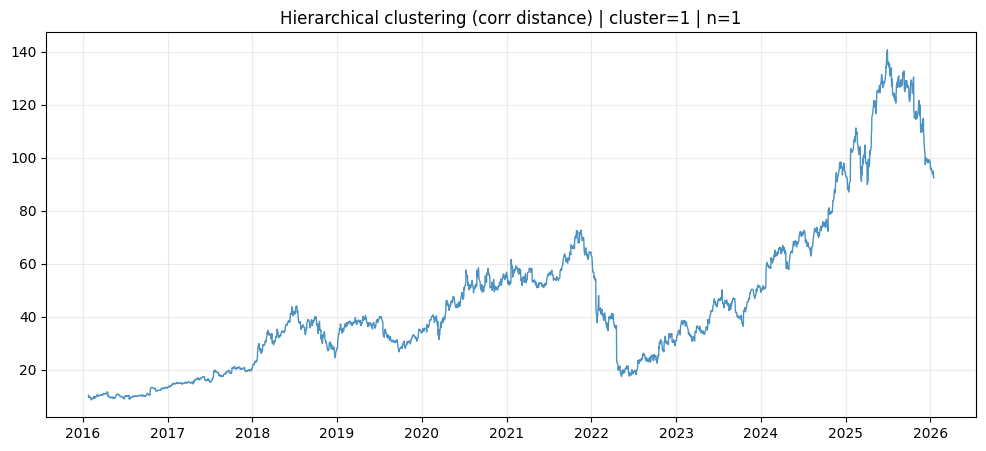

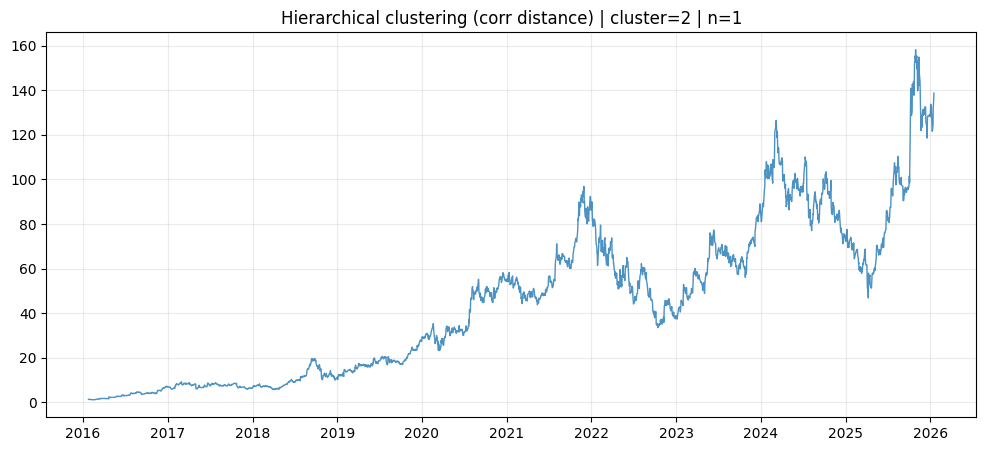

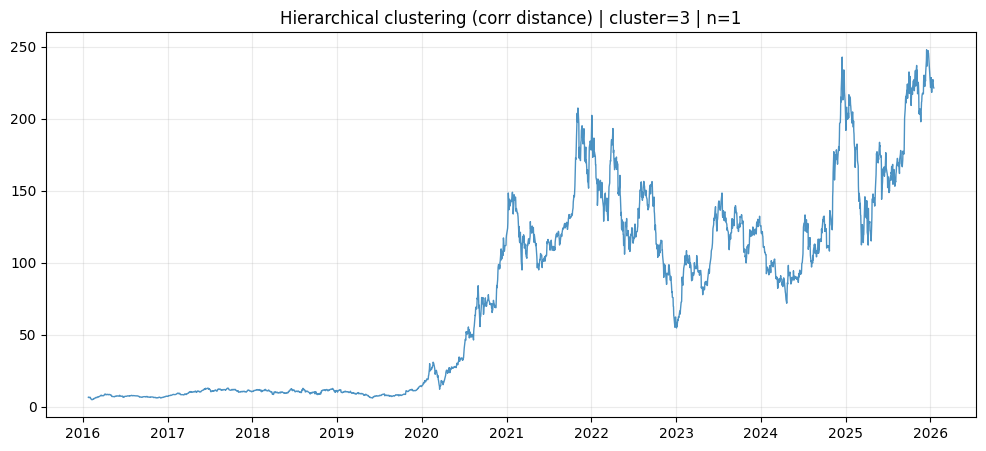

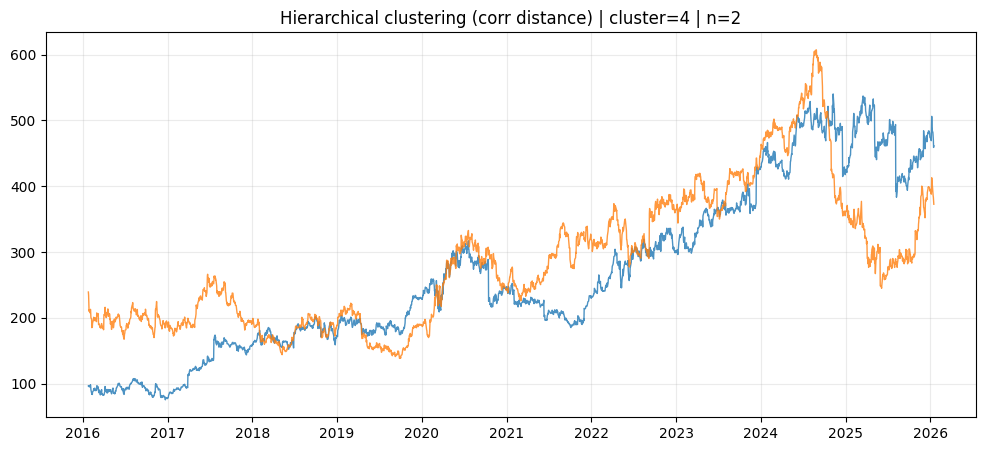

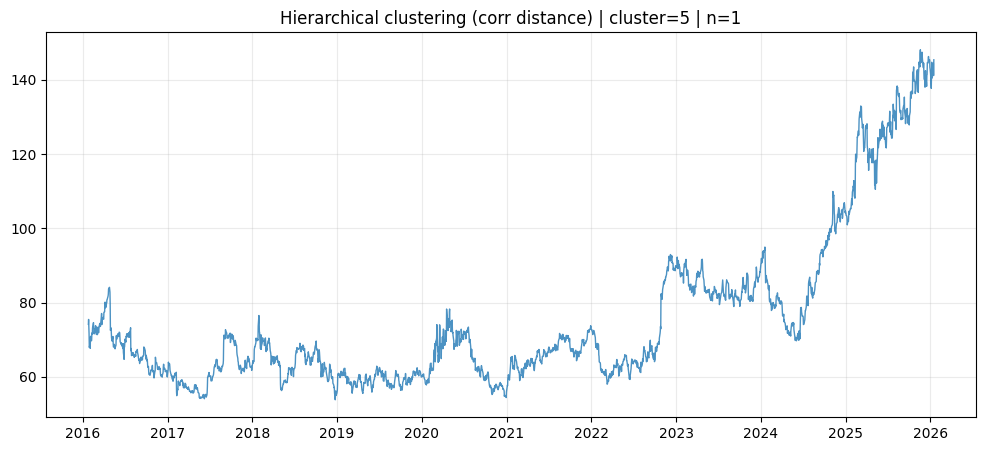

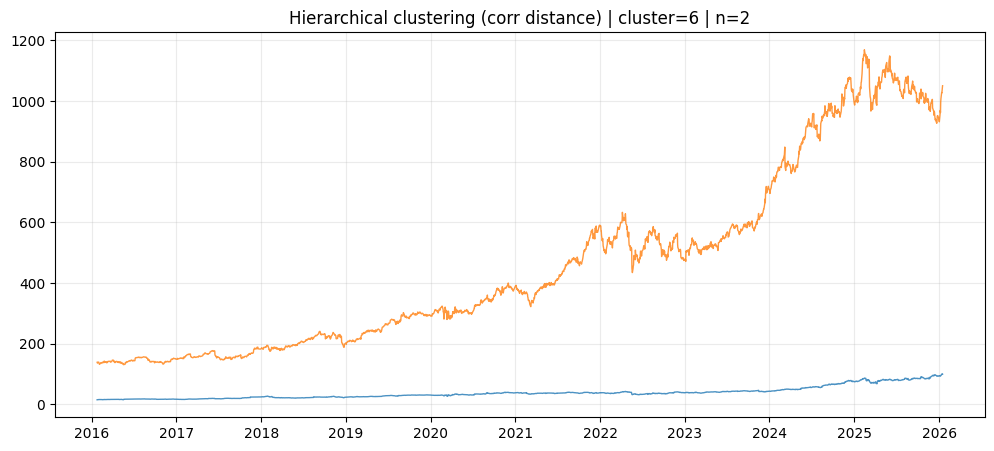

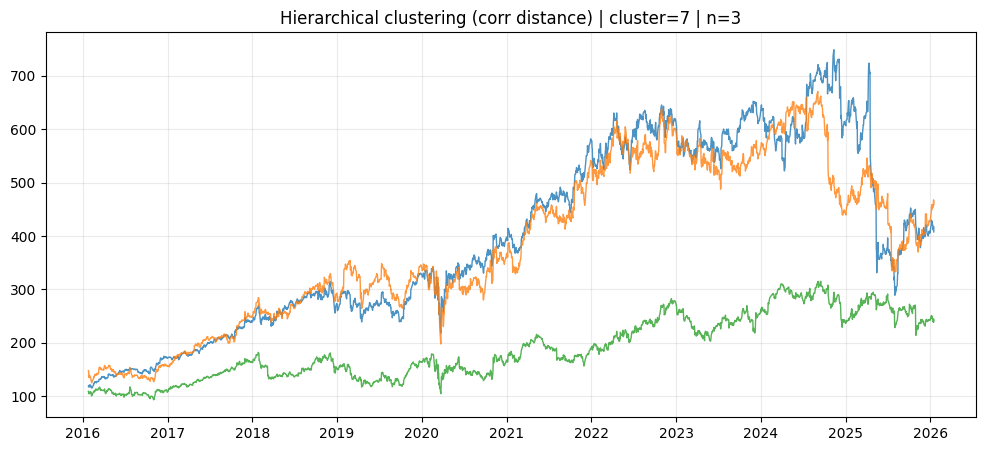

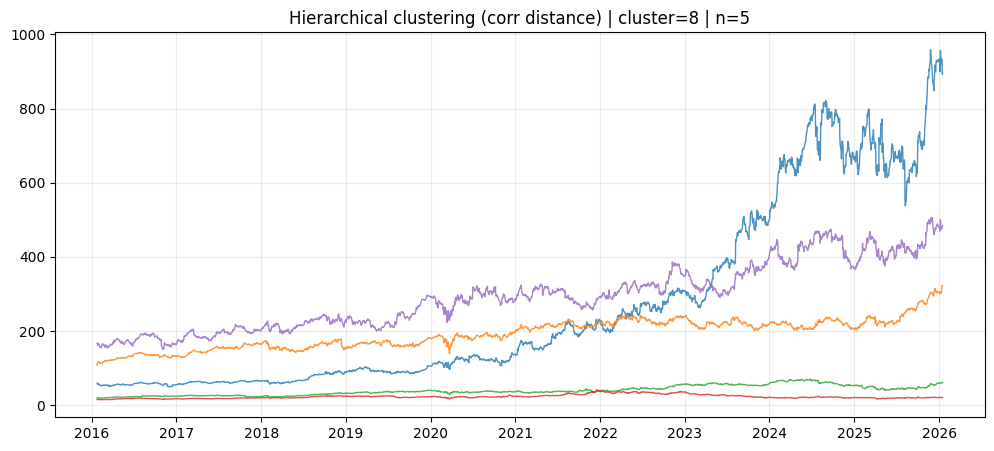

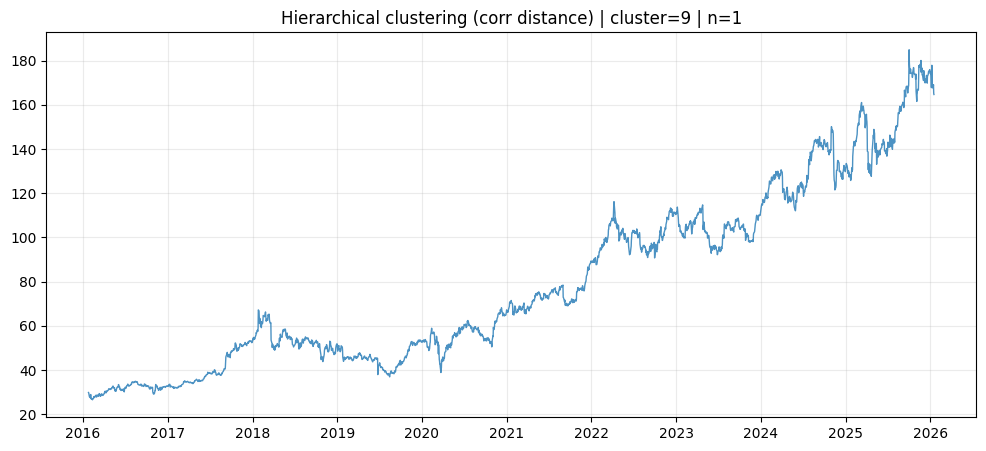

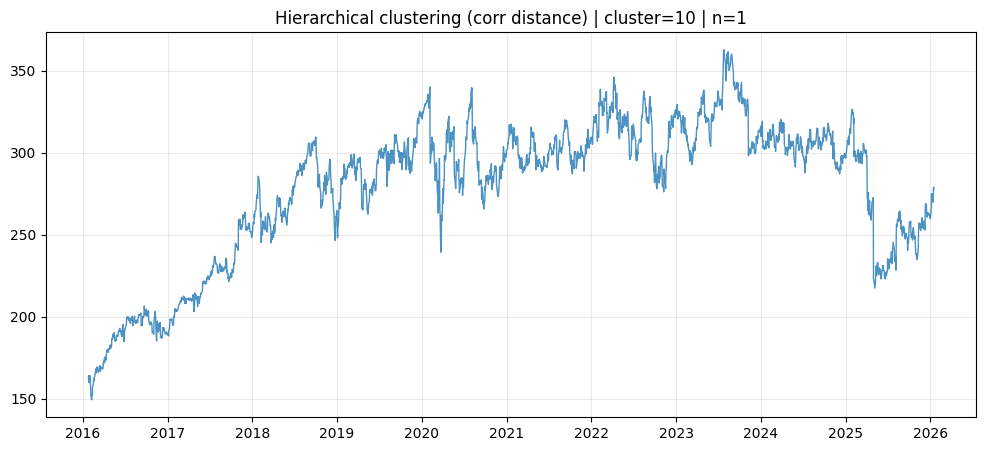

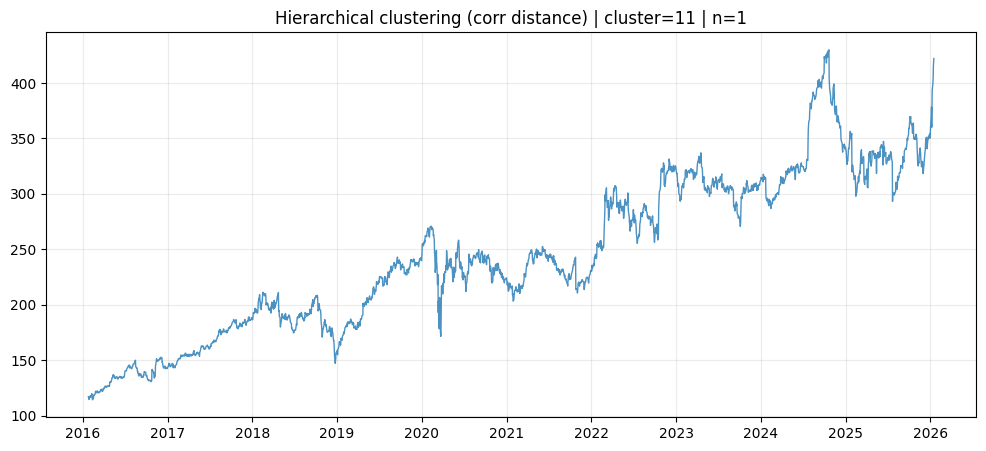

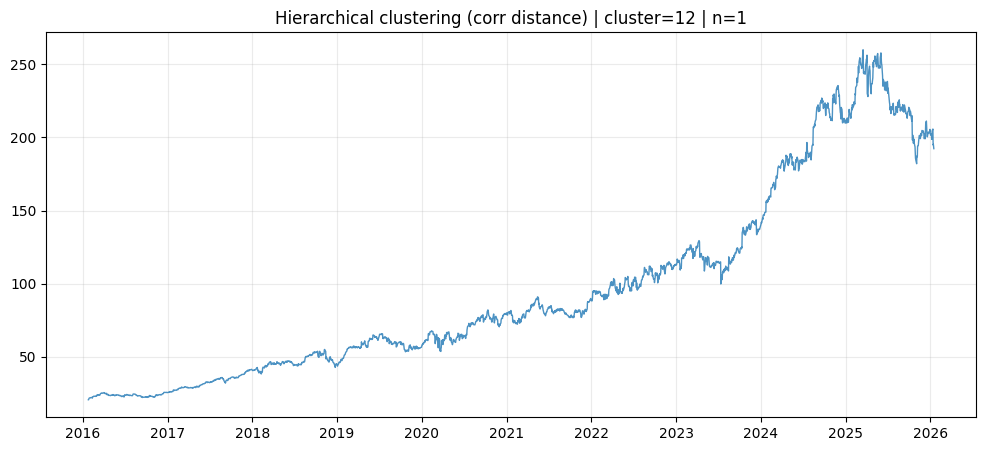

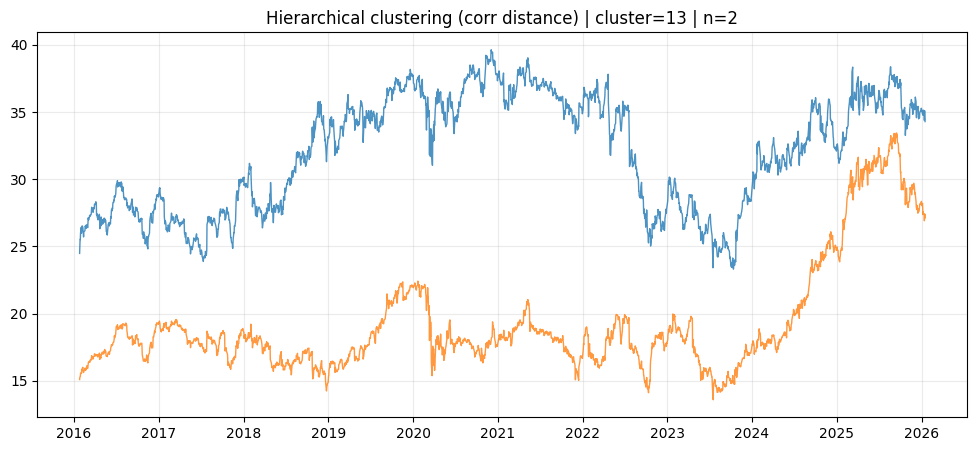

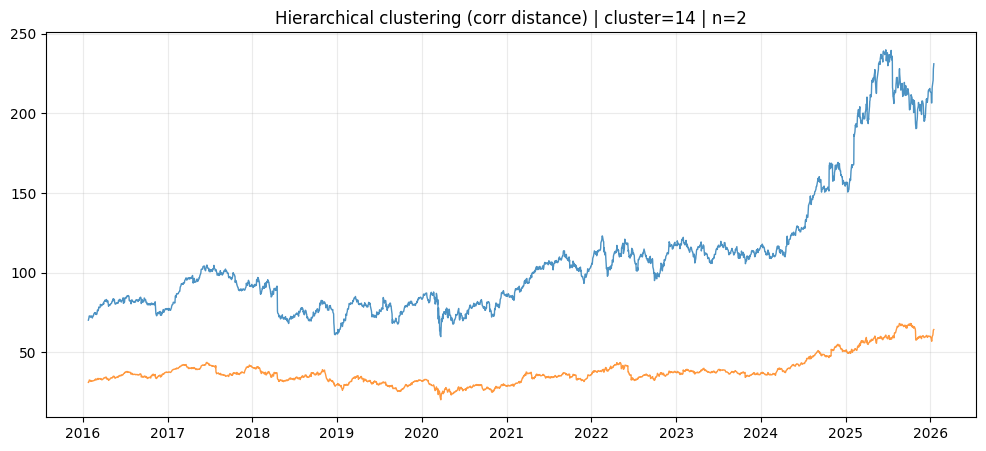

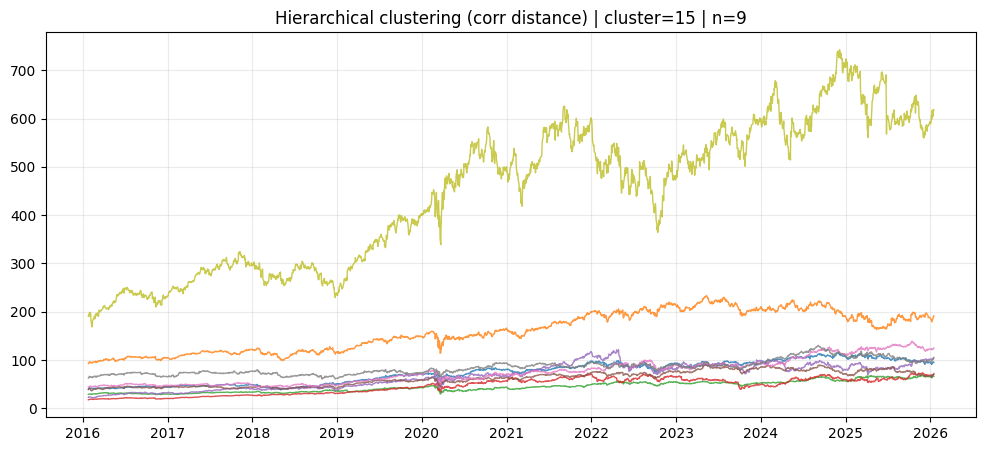

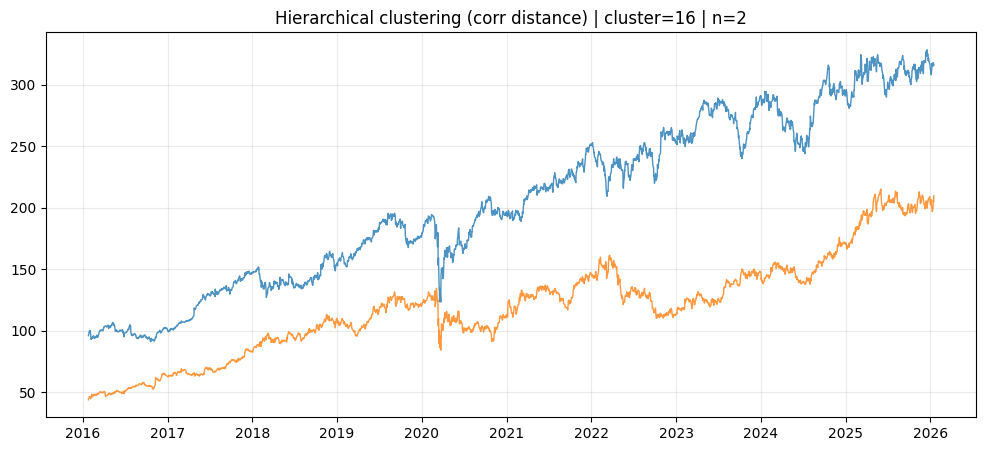

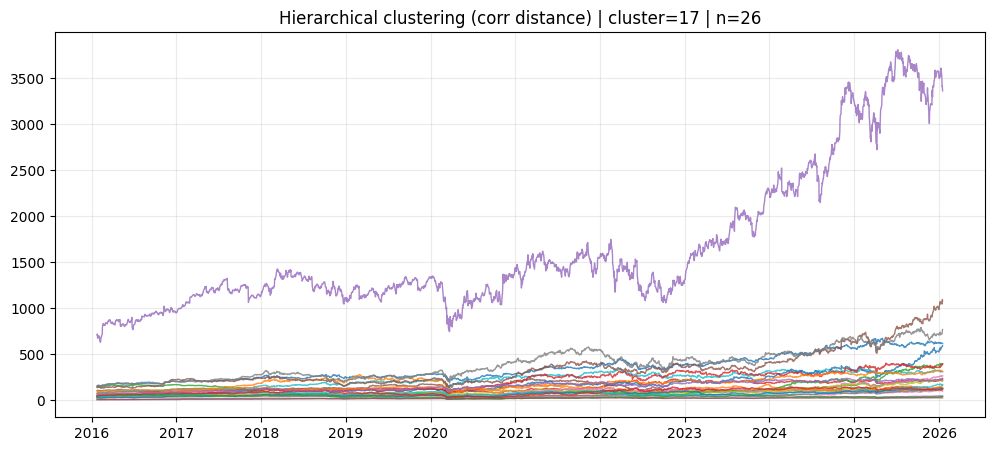

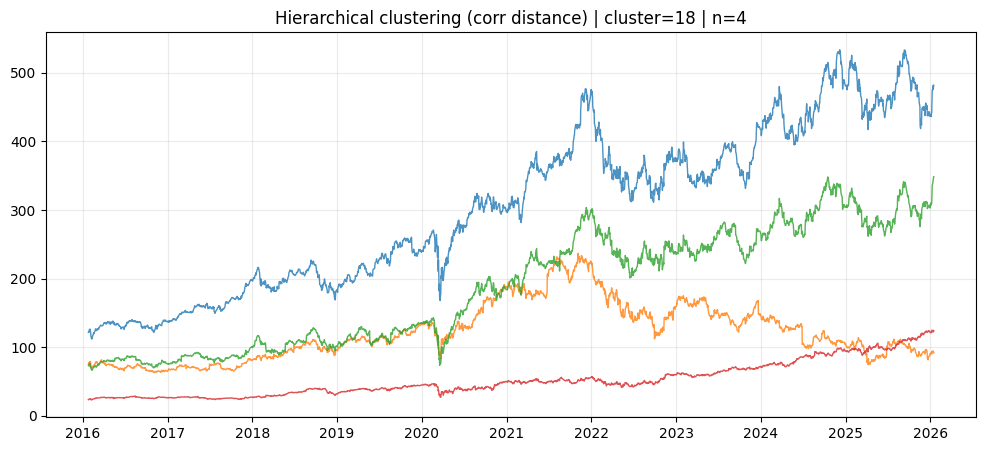

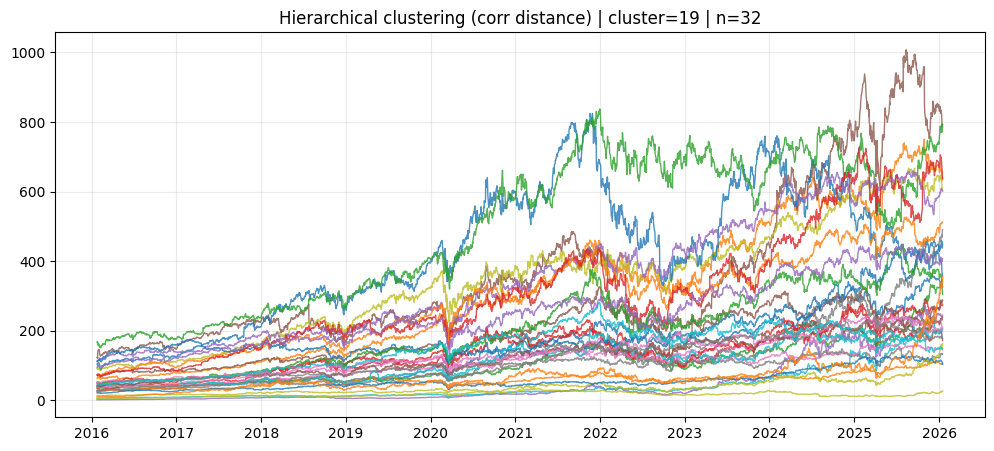

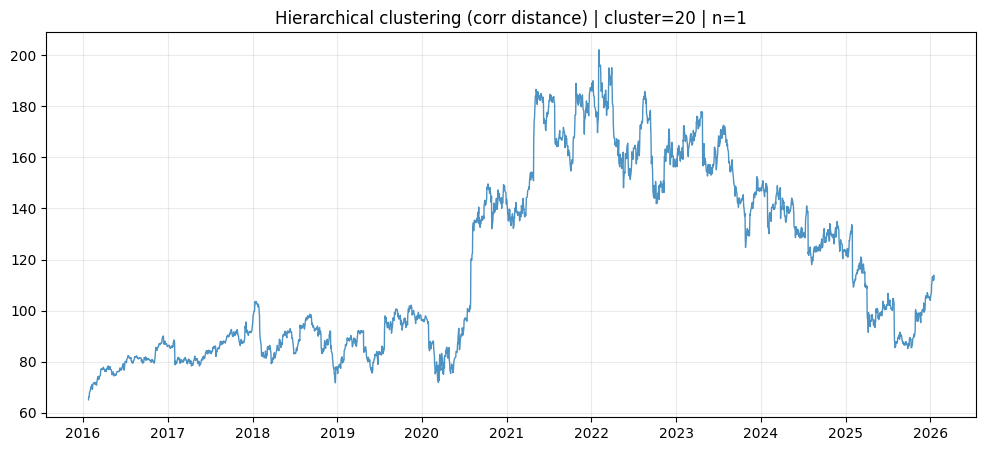

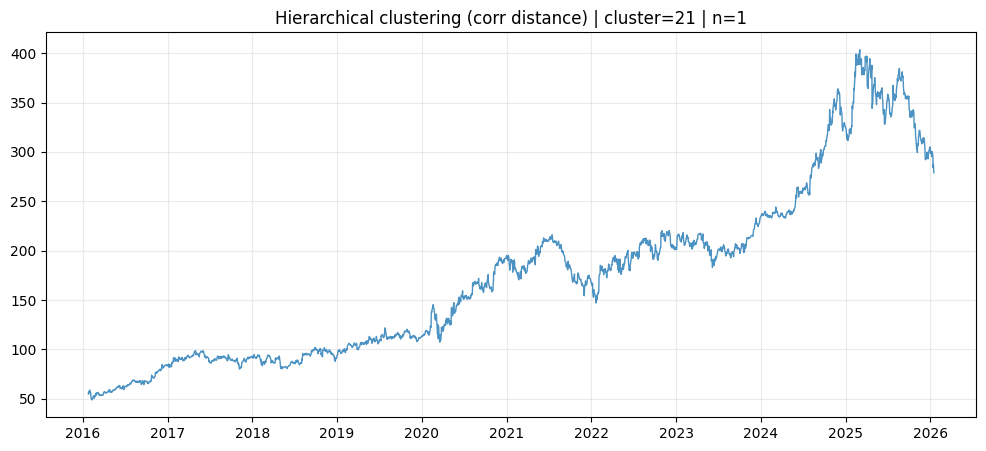

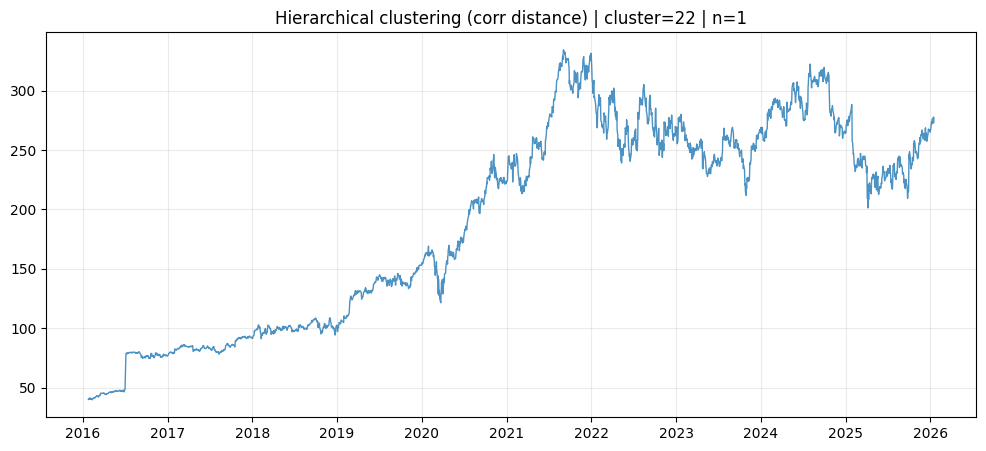

In [5]:
# 1) Hierarchical clustering on correlation distance (train window)

ret = close_daily.loc[start:train_end].pct_change().dropna(how='all')
ret = ret.dropna(axis=1, how='any')
assets = ret.columns.tolist()

corr = ret.corr().fillna(0.0)
dist = (1.0 - corr.abs()).clip(lower=0.0)

Z = linkage(squareform(dist.values, checks=False), method='average')

# Choose clusters by max distance threshold (tuneable)
MAX_DIST = 0.5
labels = fcluster(Z, t=MAX_DIST, criterion='distance')

hier_groups: dict[int, list[str]] = {}
for a, lab in zip(assets, labels):
    hier_groups.setdefault(int(lab), []).append(a)

print('hier_clusters:', len(hier_groups), 'sizes:', sorted([len(v) for v in hier_groups.values()], reverse=True)[:10])
display(cointegration_summary(hier_groups, close_daily, start_dt=start, end_dt=train_end))
plot_cluster_prices(hier_groups, close_daily, title_prefix='Hierarchical clustering (corr distance)')


dbscan labels: [-1, 0, 1, 2, 3]
noise: 42


cluster  n_assets  n_pairs  pval_median  pval_10pct
1        1         3        3     0.159777    0.065796
3        3         5       10     0.187159    0.014474
0        0        46      300     0.453474    0.087174
2        2         4        6     0.753265    0.570395

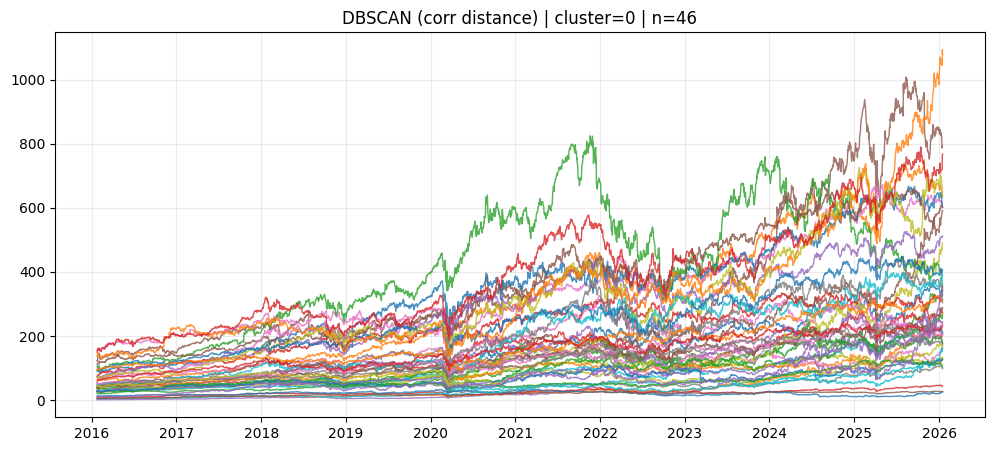

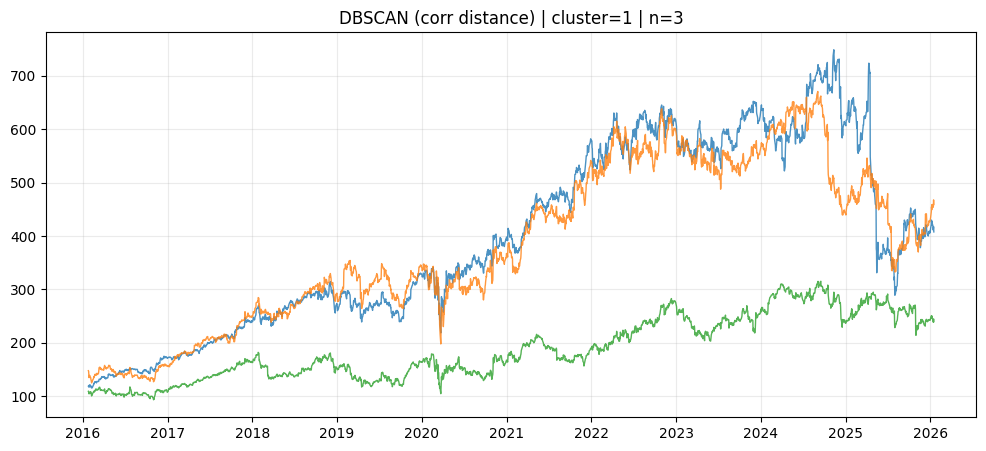

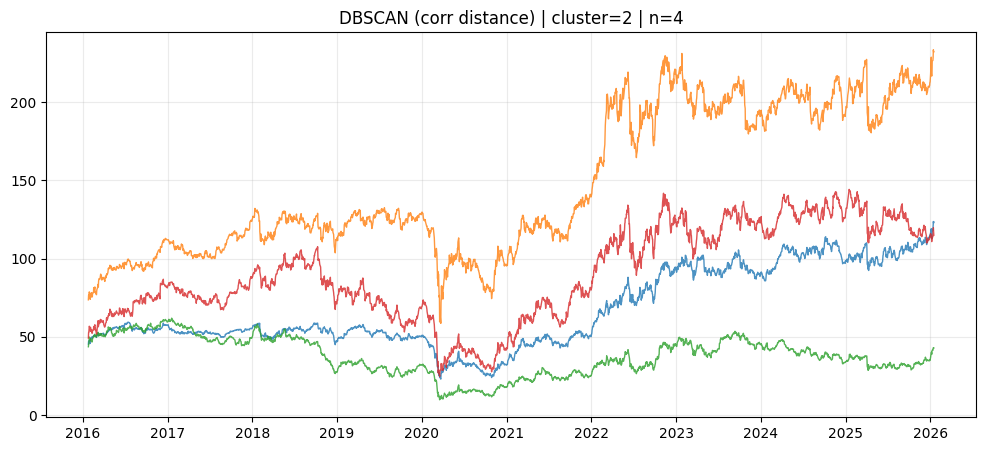

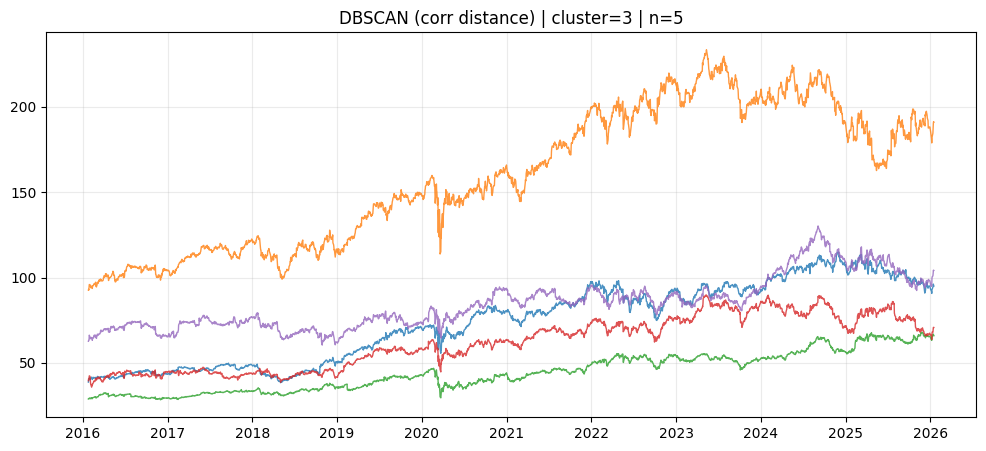

In [6]:
# 2) Density-based clustering (DBSCAN) on correlation distance (train)

# DBSCAN expects a distance matrix; use precomputed distances
EPS = 0.35
MIN_SAMPLES = 3

db = DBSCAN(eps=EPS, min_samples=MIN_SAMPLES, metric='precomputed')
db_labels = db.fit_predict(dist.values)

# db_labels = -1 are noise points

db_groups: dict[int, list[str]] = {}
for a, lab in zip(assets, db_labels):
    db_groups.setdefault(int(lab), []).append(a)

print('dbscan labels:', sorted(db_groups.keys()))
# drop noise cluster=-1 from plotting if too large
if -1 in db_groups:
    print('noise:', len(db_groups[-1]))

core_groups = {k: v for k, v in db_groups.items() if k != -1}
display(cointegration_summary(core_groups, close_daily, start_dt=start, end_dt=train_end))
plot_cluster_prices(core_groups, close_daily, title_prefix='DBSCAN (corr distance)')


gmm clusters: 8


cluster  n_assets  n_pairs  pval_median  pval_10pct
4        1        11       55     0.191082    0.025205
3        0        14       91     0.335189    0.033694
7        5        21      210     0.352703    0.045933
1        4        10       45     0.357828    0.071096
6        3        13       78     0.358980    0.024431
0        7        17      136     0.486644    0.051385
2        2        10       45     0.561877    0.119334
5        6         4        6     0.753265    0.570395

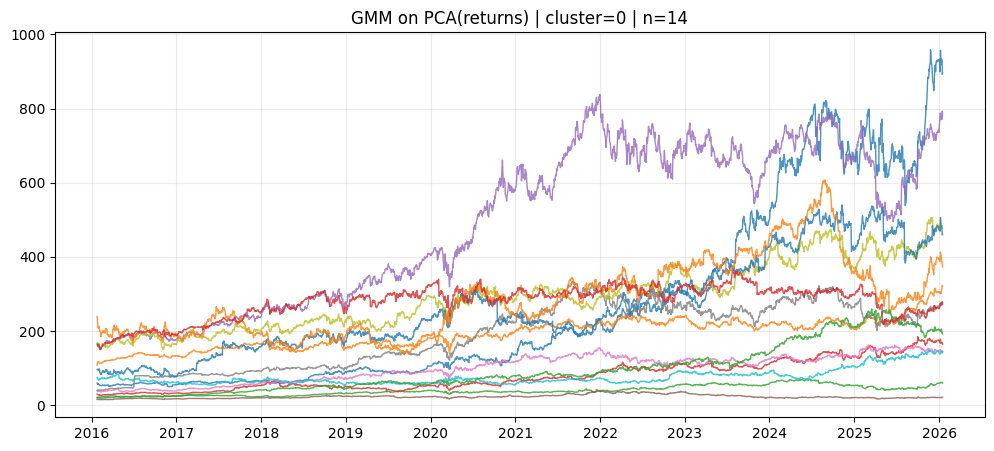

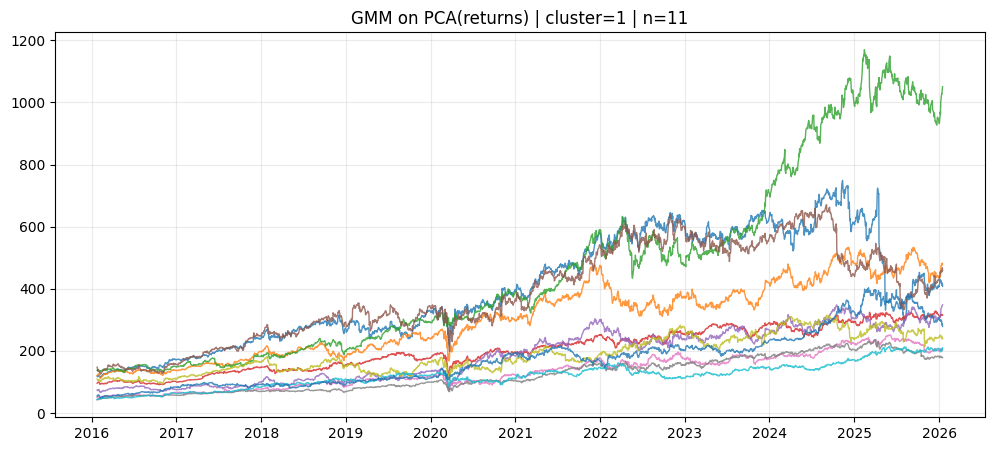

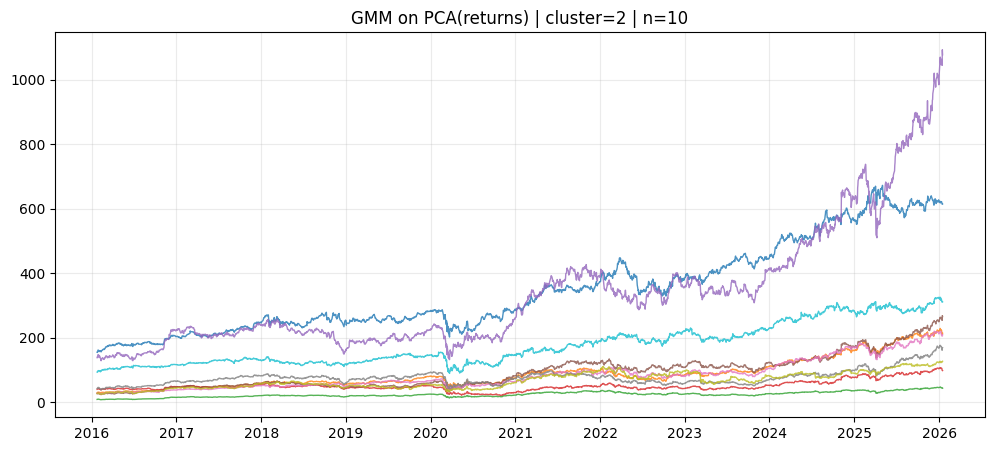

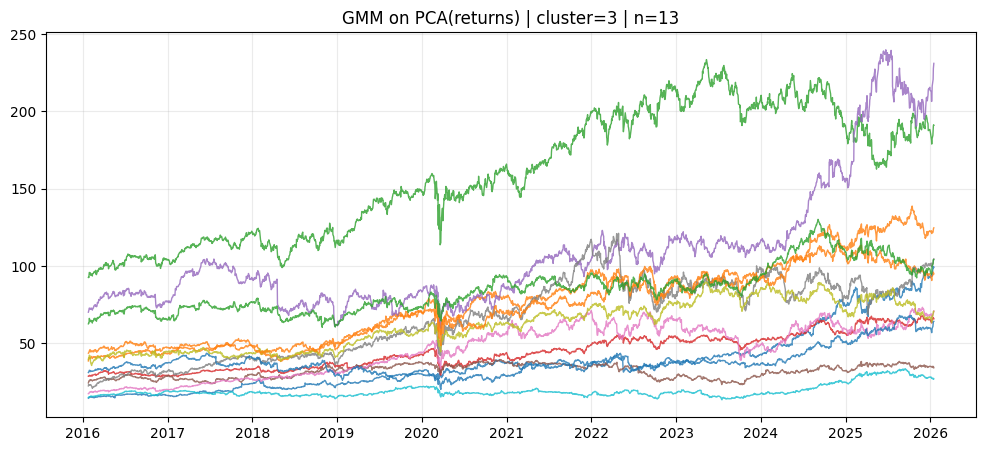

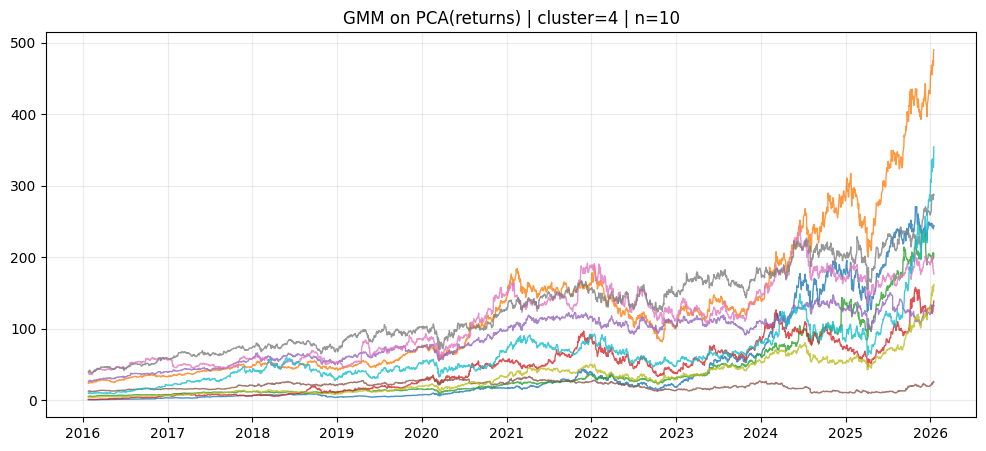

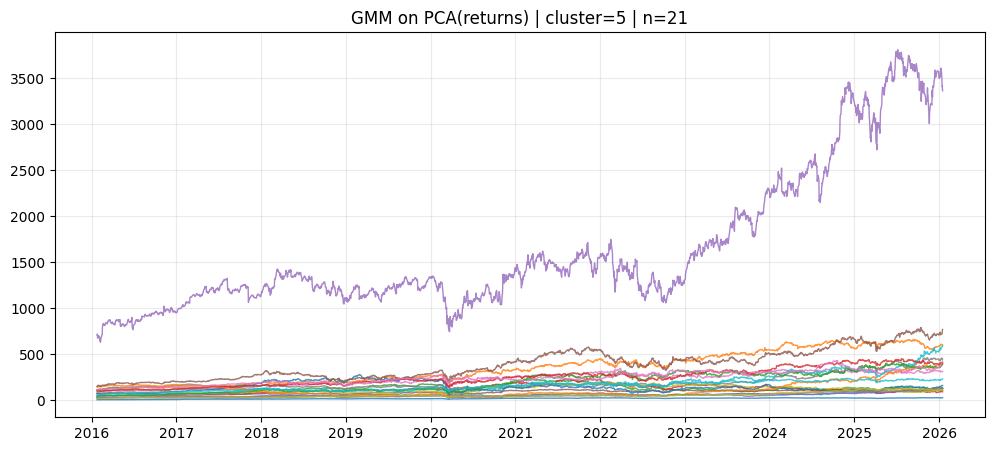

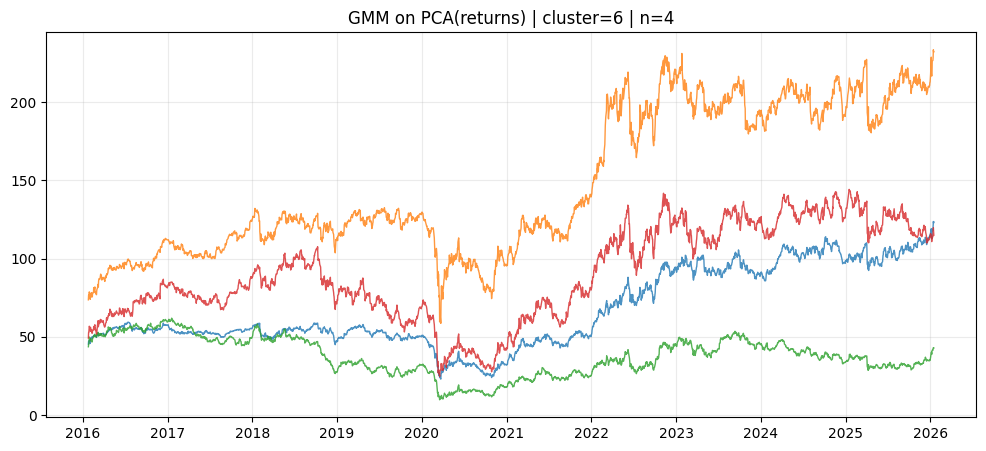

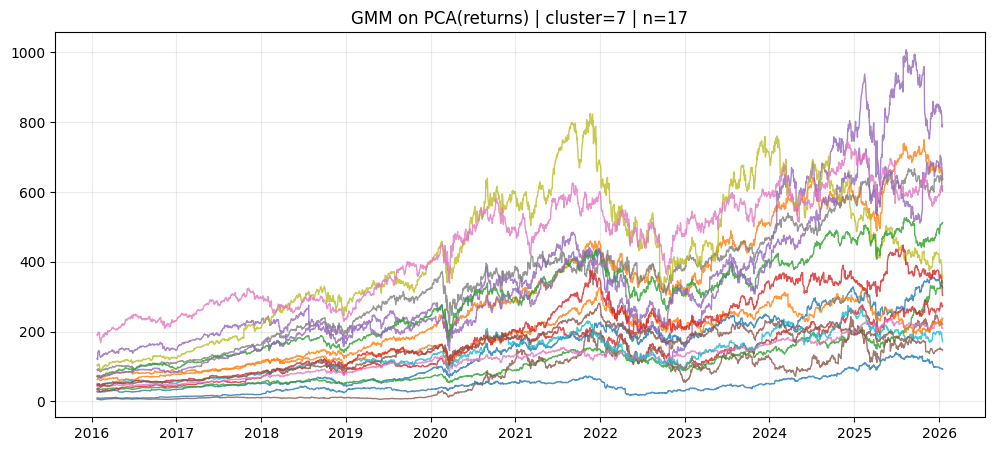

In [7]:
# 3) Gaussian Mixture Models (GMM) on PCA embedding of standardized returns (train)

X = ret.to_numpy(dtype=float)
X = np.nan_to_num(X, nan=0.0)

# Standardize time dimension
X_std = StandardScaler().fit_transform(X)

# Embed asset vectors: we want assets as samples, so transpose
X_assets = X_std.T

pca = PCA(n_components=10, random_state=42)
emb = pca.fit_transform(X_assets)

N_CLUSTERS = 8

gmm = GaussianMixture(n_components=N_CLUSTERS, covariance_type='full', random_state=42)
gmm_labels = gmm.fit_predict(emb)

gmm_groups: dict[int, list[str]] = {}
for a, lab in zip(assets, gmm_labels):
    gmm_groups.setdefault(int(lab), []).append(a)

print('gmm clusters:', len(gmm_groups))
display(cointegration_summary(gmm_groups, close_daily, start_dt=start, end_dt=train_end))
plot_cluster_prices(gmm_groups, close_daily, title_prefix='GMM on PCA(returns)')


tested pairs: 2000 edges kept: 144
components: 4 largest sizes: [60, 3, 2, 2]


cluster  n_assets  n_pairs  pval_median  pval_10pct
3        3         2        1     0.001058    0.001058
1        1         3        3     0.005421    0.002054
2        2         2        1     0.033282    0.033282
0        0        60      300     0.260262    0.028592

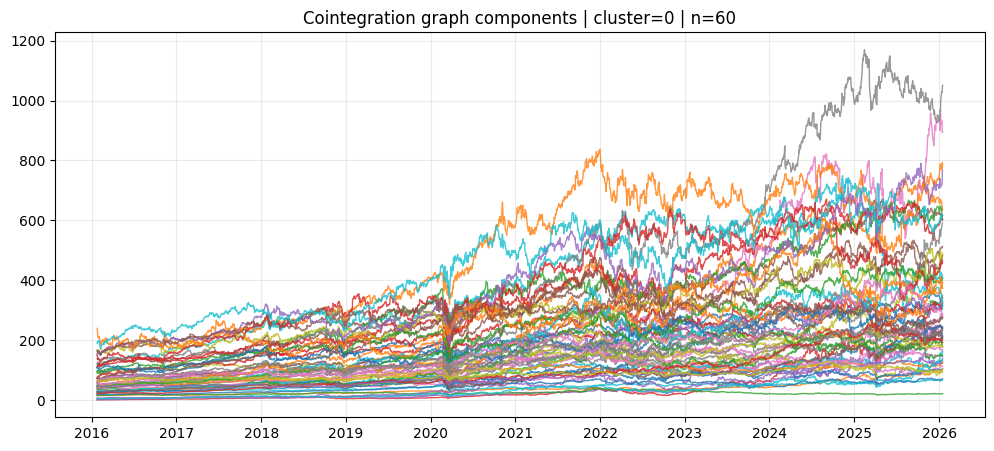

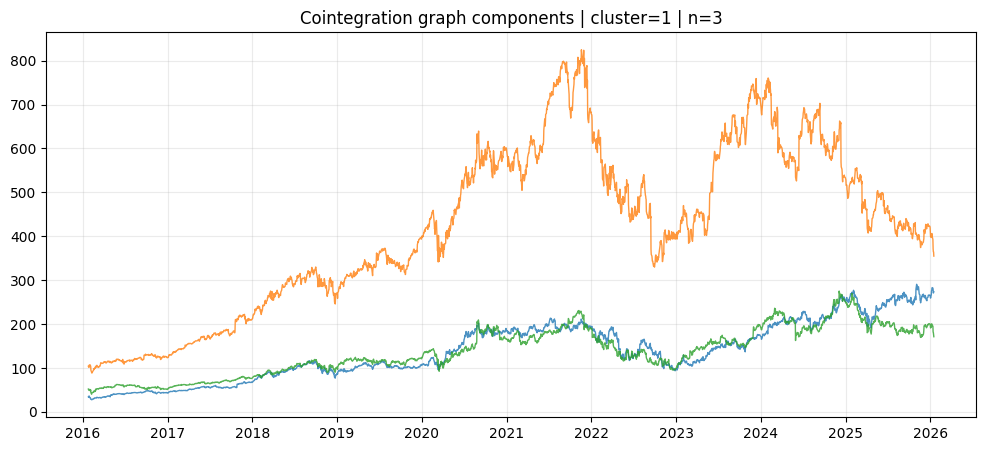

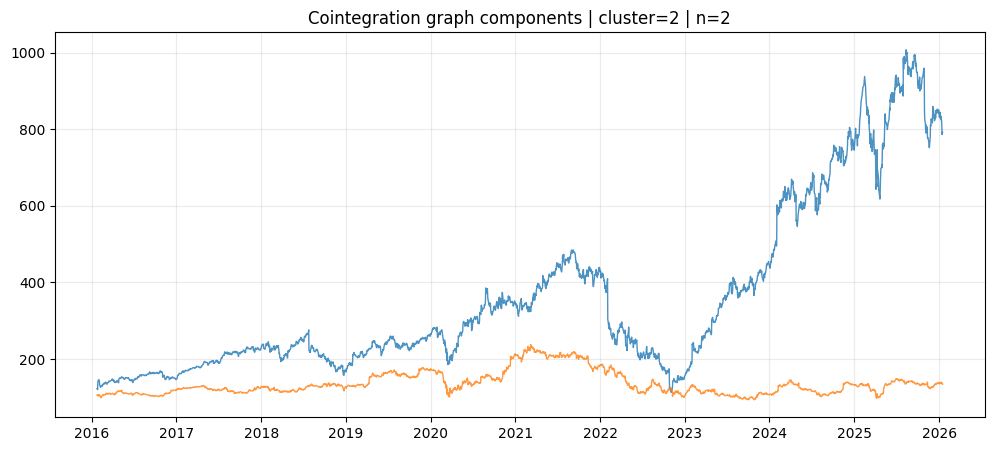

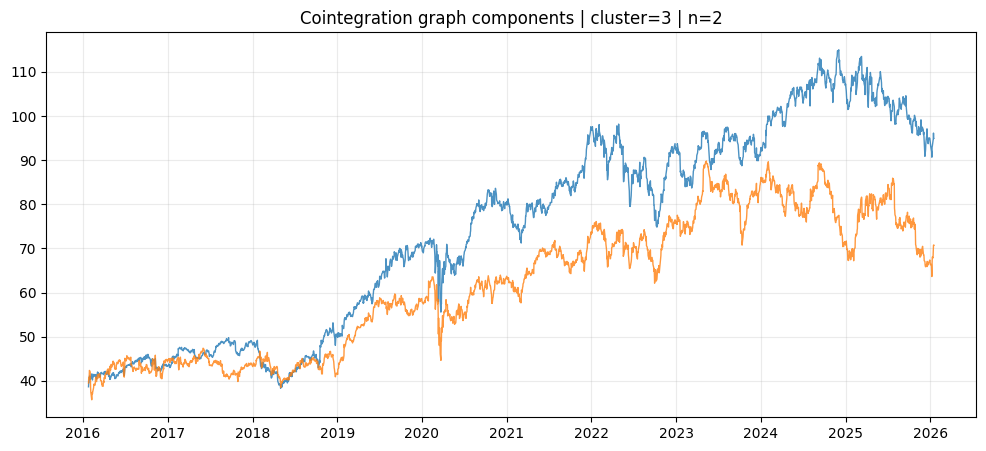

In [8]:
# 4) Cointegration baseline: build graph of pairs with pvalue < threshold (train), then connected components

PVAL_THRESH = 0.05
MAX_PAIRS = 2000  # cap for runtime safety (adjust if needed)

px = close_daily.loc[start:train_end].ffill().bfill().loc[:, assets]
logp = np.log(px.astype(float))

edges = []
count = 0
for i in range(len(assets)):
    for j in range(i + 1, len(assets)):
        if count >= MAX_PAIRS:
            break
        y = logp.iloc[:, i]
        x = logp.iloc[:, j]
        try:
            _score, pval, _ = coint(y, x)
        except Exception:
            continue
        count += 1
        if float(pval) < PVAL_THRESH:
            edges.append((assets[i], assets[j]))
    if count >= MAX_PAIRS:
        break

print('tested pairs:', count, 'edges kept:', len(edges))

# Union-find components
parent = {a: a for a in assets}

def find(a):
    while parent[a] != a:
        parent[a] = parent[parent[a]]
        a = parent[a]
    return a

def union(a,b):
    ra, rb = find(a), find(b)
    if ra != rb:
        parent[rb] = ra

for a,b in edges:
    union(a,b)

comp = {}
for a in assets:
    comp.setdefault(find(a), []).append(a)

# Assign integer cluster ids
coint_groups = {i: v for i, v in enumerate(sorted(comp.values(), key=len, reverse=True), start=0) if len(v) >= 2}
print('components:', len(coint_groups), 'largest sizes:', [len(v) for v in list(coint_groups.values())[:5]])
display(cointegration_summary(coint_groups, close_daily, start_dt=start, end_dt=train_end))
plot_cluster_prices(coint_groups, close_daily, title_prefix='Cointegration graph components')


rule ME clusters 8 sizes [50, 32, 10, 3, 2]


cluster  n_assets  n_pairs  pval_median  pval_10pct
3        3        10       45     0.228450    0.022559
0        1        50      300     0.240394    0.024274
1        4        32      300     0.461159    0.086025
2        2         3        3     0.586612    0.146604
4        0         2        1     0.642694    0.642694

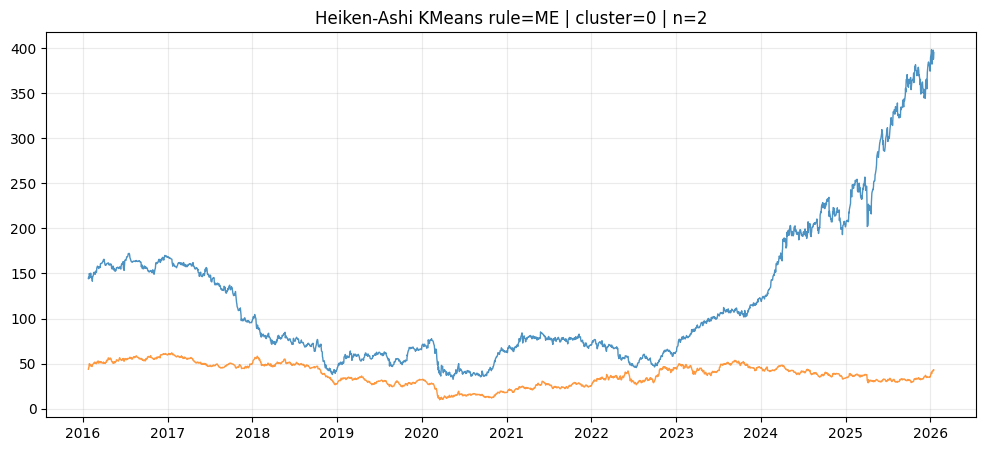

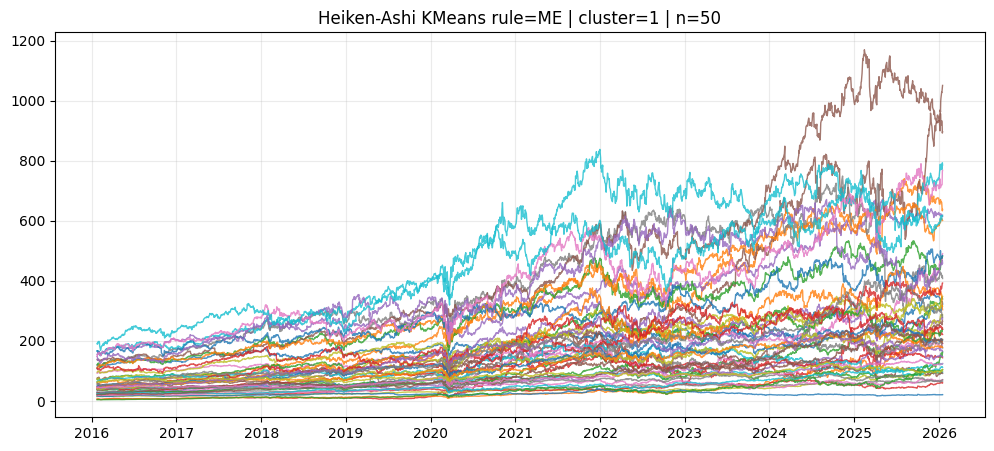

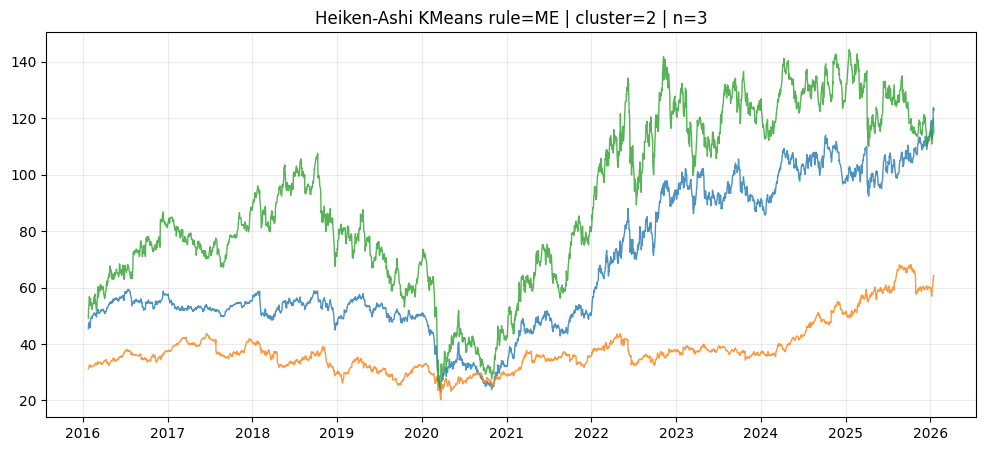

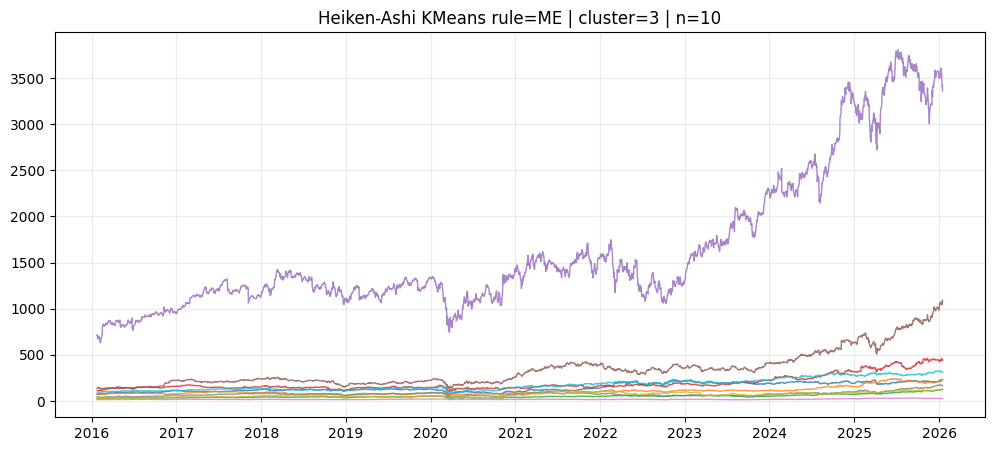

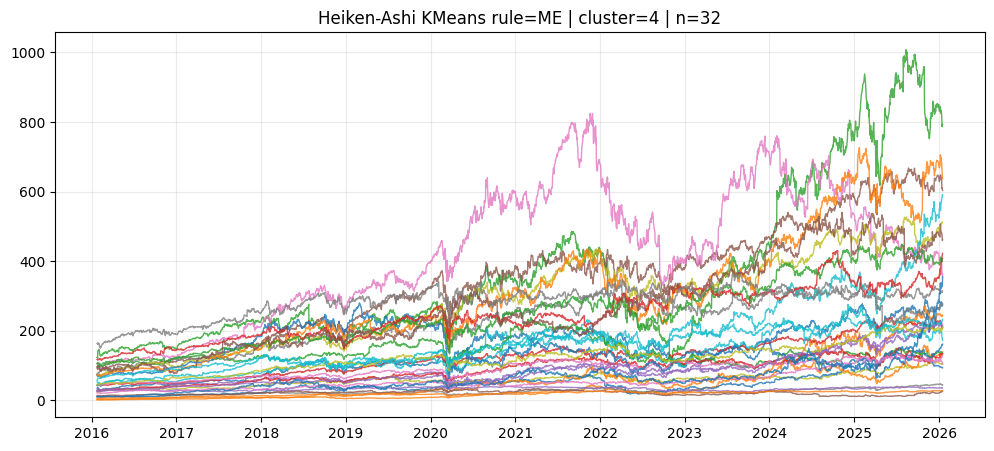

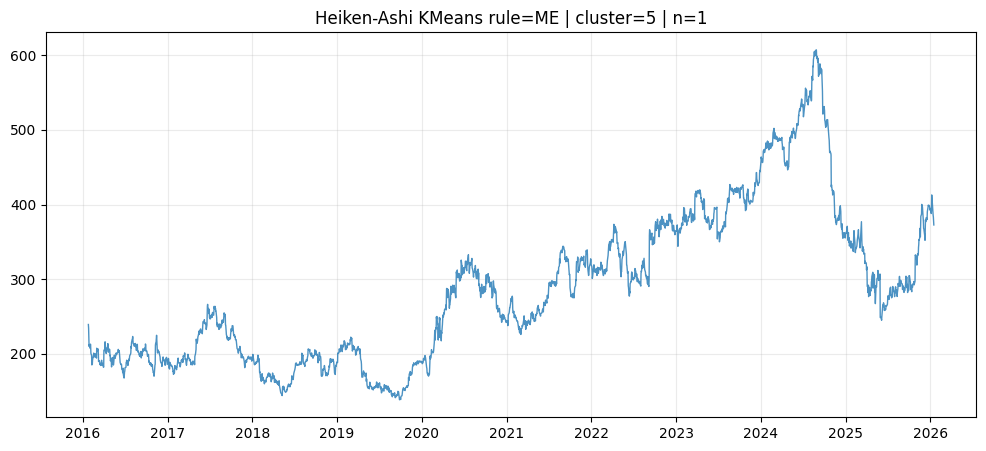

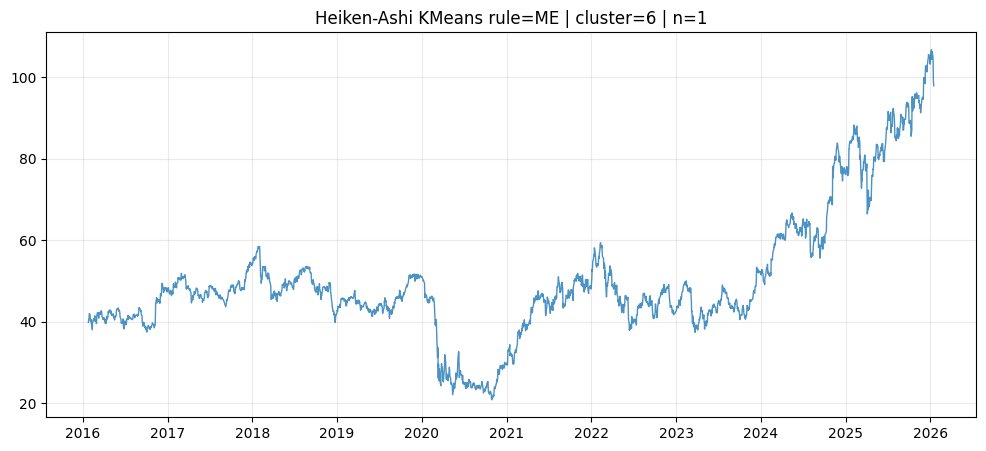

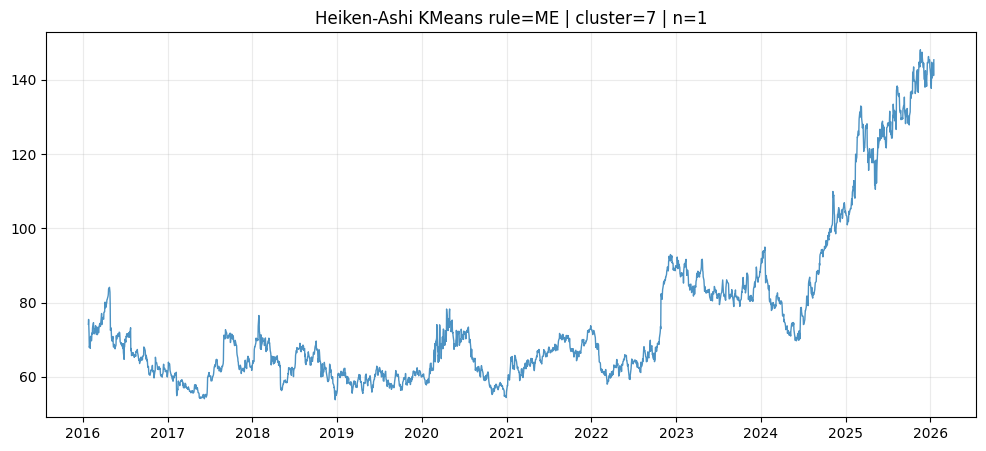

rule 3MS clusters 8 sizes [62, 20, 7, 3, 3]


cluster  n_assets  n_pairs  pval_median  pval_10pct
4        7         3        3     0.179840    0.055866
2        2        20      190     0.223211    0.021538
5        1         3        3     0.274853    0.074009
0        4        62      300     0.409777    0.039279
1        0         7       21     0.547087    0.097159
3        5         3        3     0.586612    0.438493

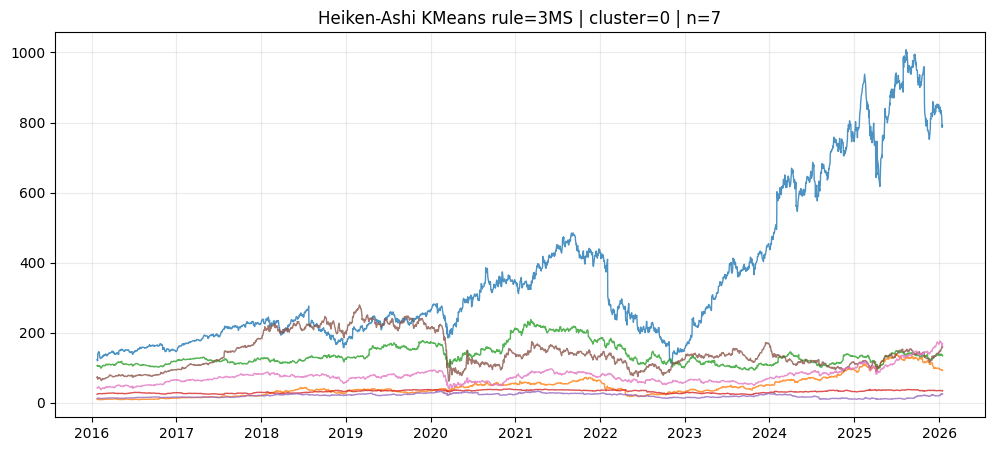

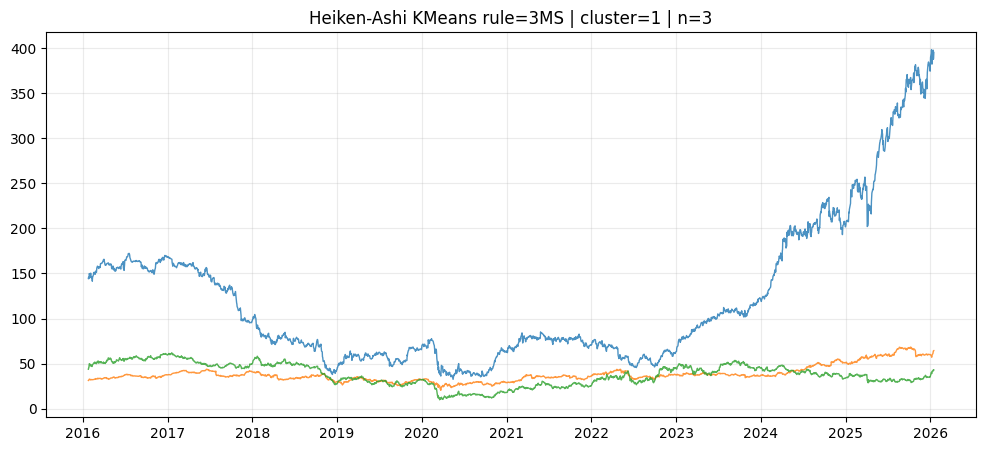

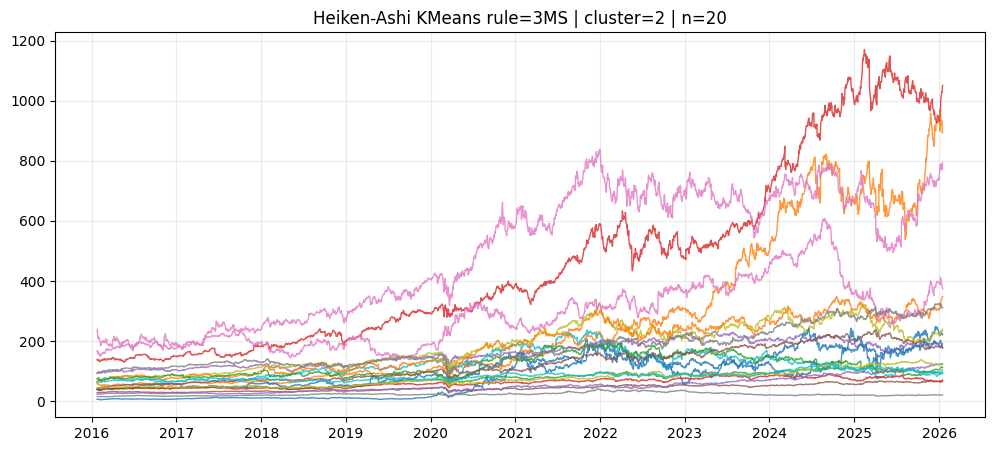

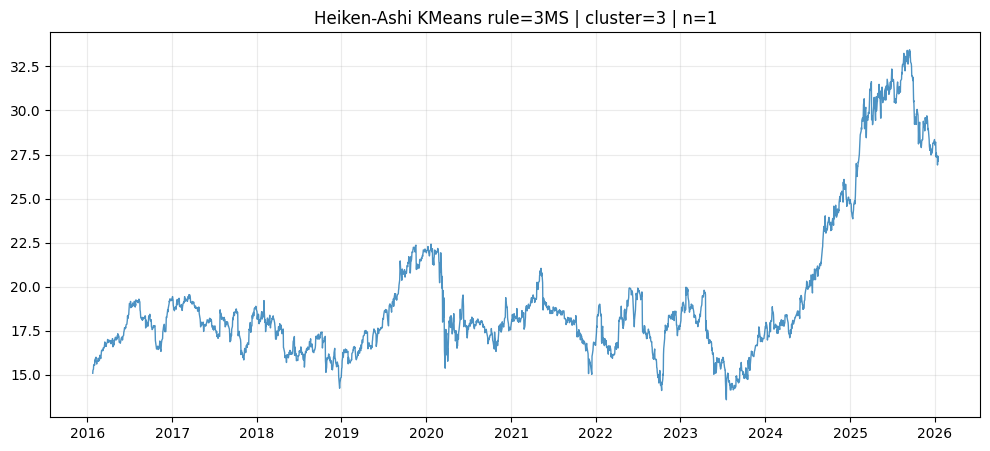

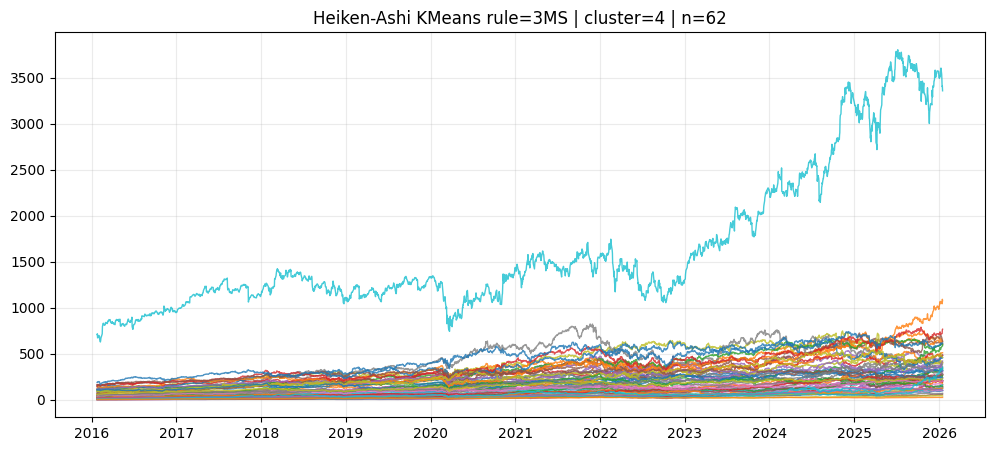

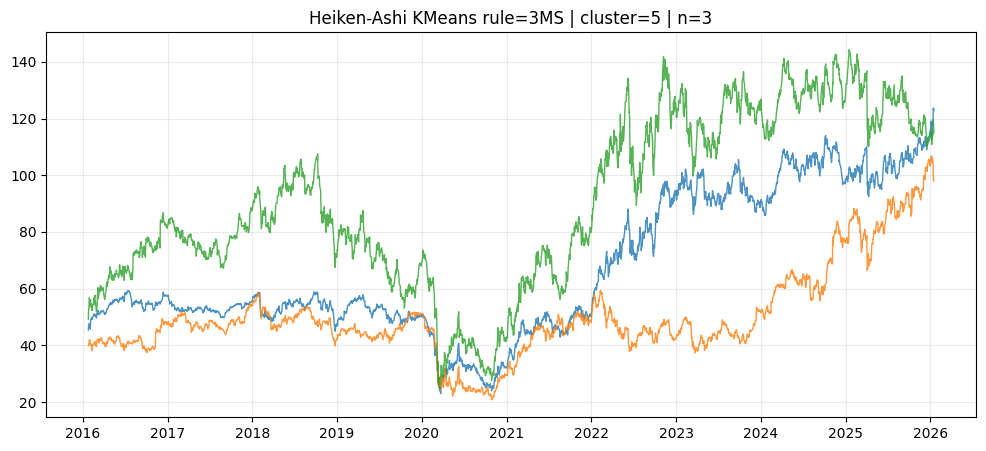

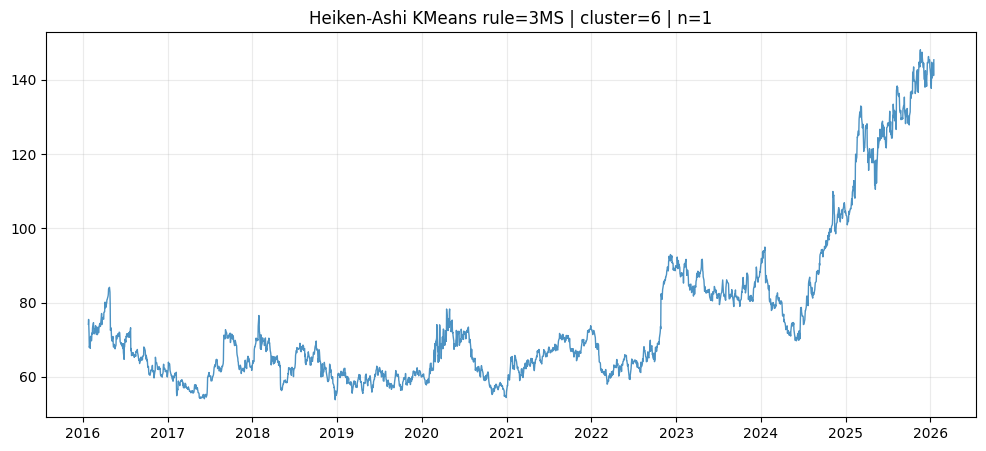

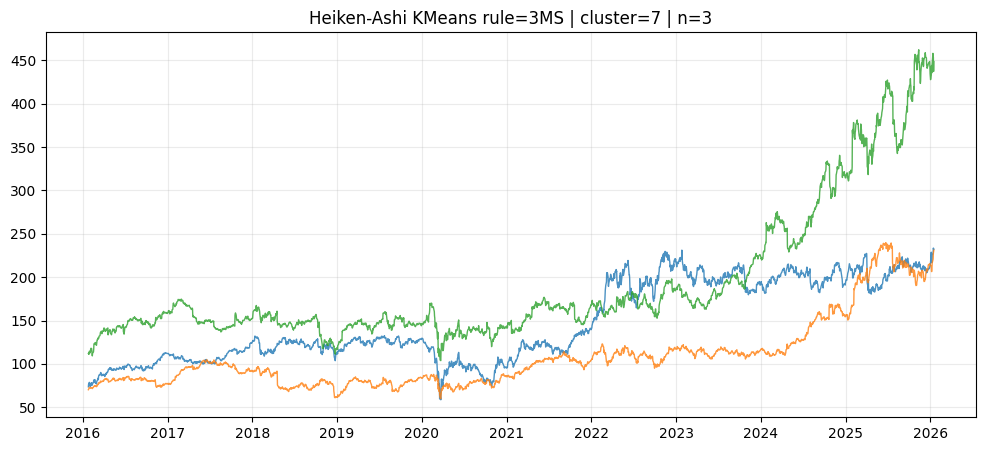

rule 6MS clusters 8 sizes [54, 29, 7, 3, 3]


cluster  n_assets  n_pairs  pval_median  pval_10pct
4        4         3        3     0.024873    0.016028
0        5        54      300     0.251479    0.018989
5        7         3        3     0.274853    0.074009
2        2        29      300     0.288942    0.028037
1        0         7       21     0.547087    0.097159
3        1         2        1     0.586612    0.586612

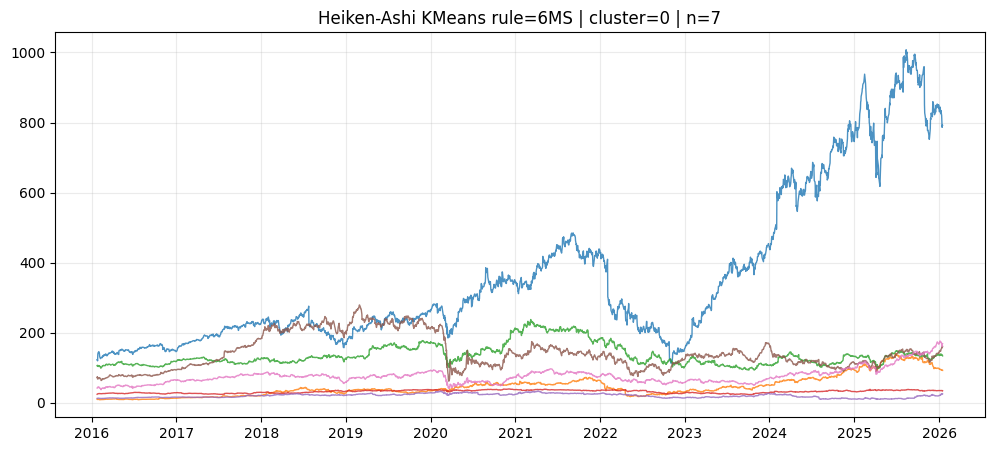

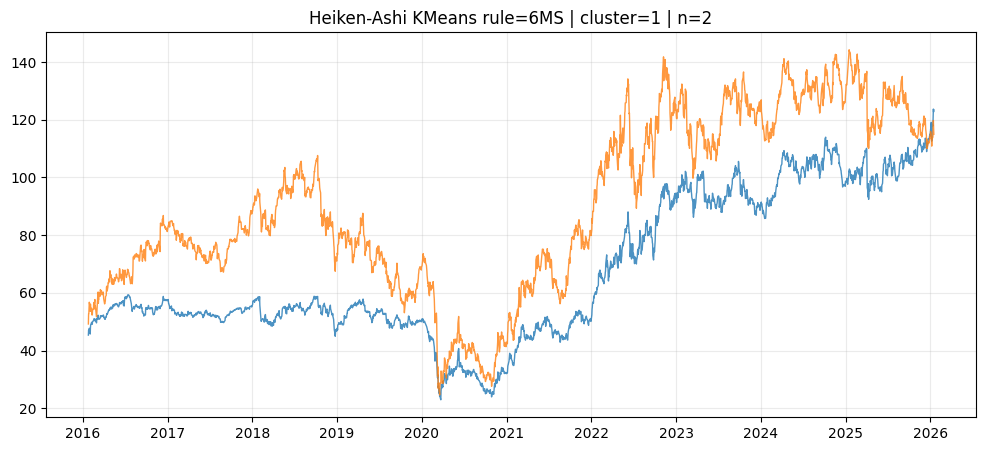

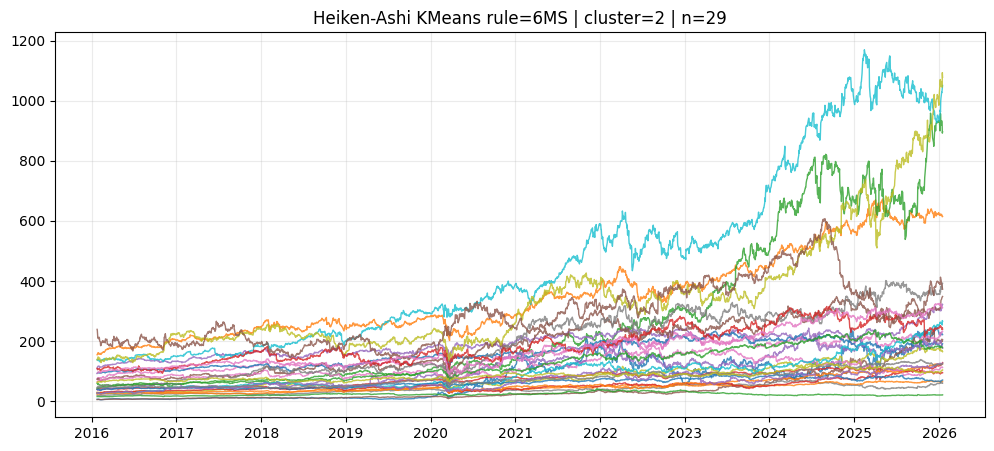

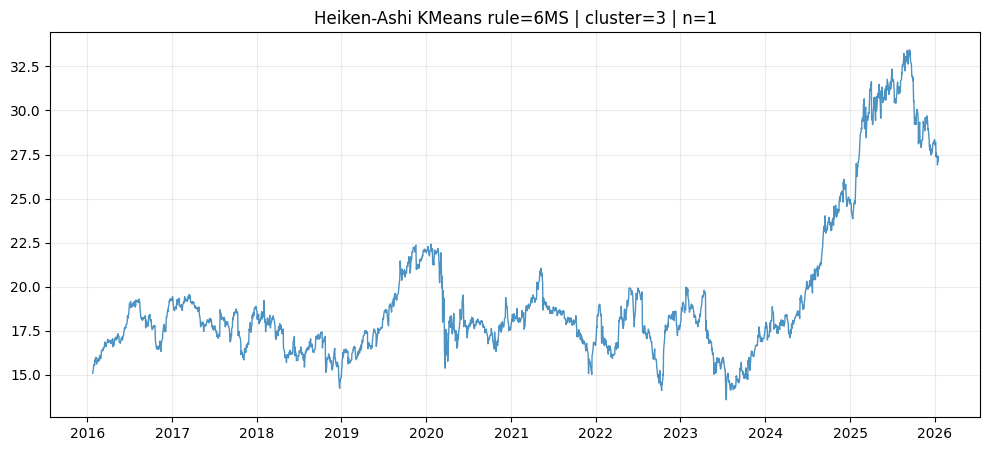

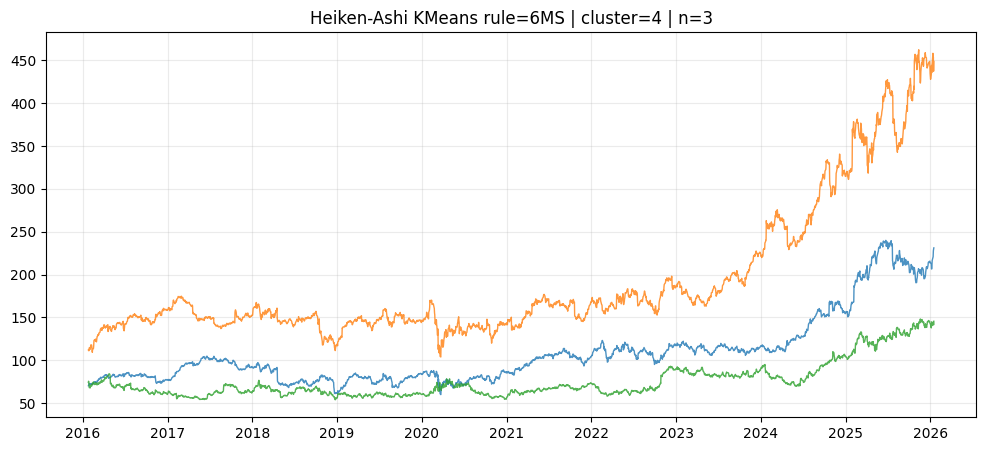

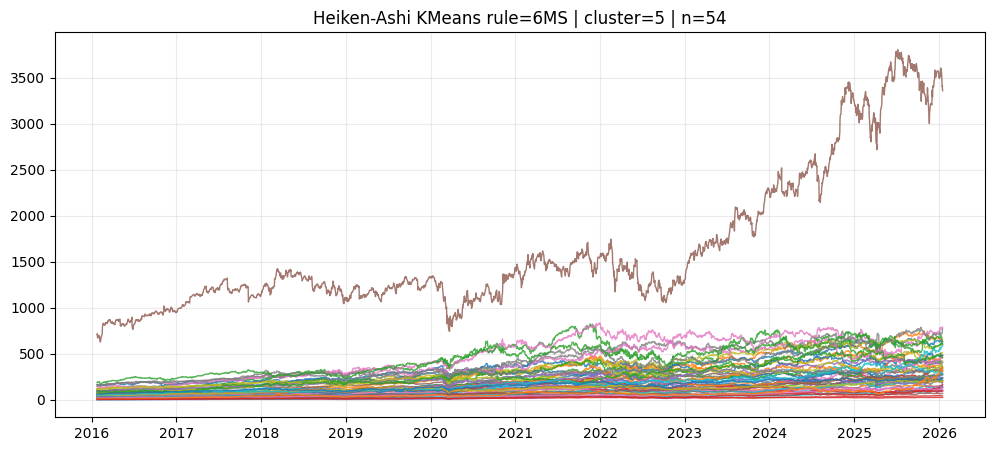

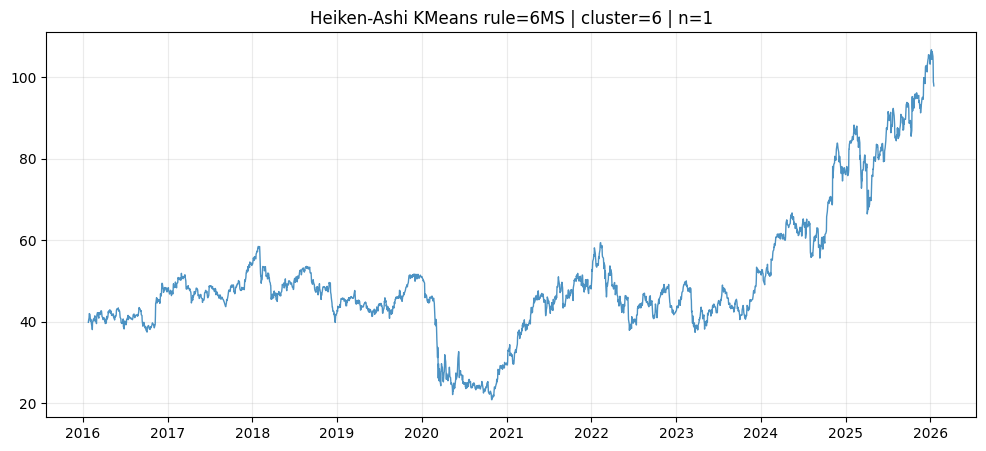

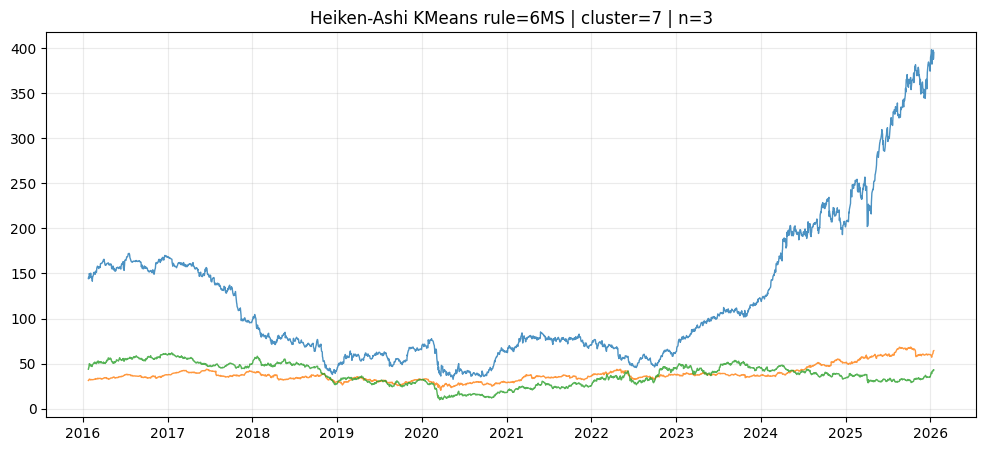

In [9]:
# 5) Heiken-Ashi slope-shape clustering variants (monthly / 3M / 6M)

from sklearn.cluster import KMeans

N_CLUSTERS = 8

for rule in ['ME', '3MS', '6MS']:
    ha_close = build_heiken_ashi_close(rule)
    X, ha_assets = slope_shape_X(ha_close, start_dt=start, end_dt=train_end)
    km = KMeans(n_clusters=N_CLUSTERS, random_state=42, n_init=10)
    lab = km.fit_predict(X)

    groups: dict[int, list[str]] = {}
    for a, l in zip(ha_assets, lab):
        groups.setdefault(int(l), []).append(a)

    print('rule', rule, 'clusters', len(groups), 'sizes', sorted([len(v) for v in groups.values()], reverse=True)[:5])
    display(cointegration_summary(groups, close_daily, start_dt=start, end_dt=train_end))
    plot_cluster_prices(groups, close_daily, title_prefix=f'Heiken-Ashi KMeans rule={rule}')
